In [84]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import h5py
from collections import defaultdict

from timeit import default_timer as timer

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder 

import torch
import torchvision.transforms as transforms
from skimage.util import random_noise

from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras import layers, models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout, Reshape
from keras.optimizers import Adam
from keras.losses import mean_squared_error, categorical_crossentropy, binary_crossentropy
from keras.callbacks import EarlyStopping
from keras.metrics import MeanIoU, IoU
import keras.backend as K

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose
from tensorflow.keras.metrics import Recall, Precision, MeanAbsoluteError
from tensorflow.keras.utils import plot_model

In [85]:
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
working_path = os.path.join(parent_dir) #incase directory needs to be expanded
downloads_path = os.path.expanduser("~\\Downloads")
extract_dir = os.path.expanduser("~\\Data_science")

In [86]:
# Set up folder paths
# Define the source paths for images and annotations
image_pool_path = os.path.join(extract_dir, 'VOC_PCB', 'JPEGImages')
annot_pool_path = os.path.join(extract_dir, 'VOC_PCB', 'Annotations')

# Define the destination path for images and annotations
image_dest_path = os.path.join(working_path, 'data', 'Images')
annot_dest_path = os.path.join(working_path, 'data', 'Annotations')

# Define the destination path for bboxes and masks
bb_path = os.path.join(working_path, 'data', 'Images_bb')
mask_path = os.path.join(working_path, 'data', 'Pixel_masks')

# Define the destination path for csv file
csv_path = os.path.join(working_path, 'data', 'csv')

In [87]:
image_dataset_path = image_dest_path

In [88]:
# train and test dataset file paths
train_path =  os.path.join(downloads_path, "train_data.h5")
test_path =  os.path.join(downloads_path, "test_data.h5")

Loading Training and Testing datasets

In [89]:
# load train dataset
with h5py.File(train_path, 'r') as hf:
    X_train = hf['X'][:]
    y_train_mask = hf['y_mask'][:]
    y_train_class = hf['y_class'][:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train_mask shape: {y_train_mask.shape}")
print(f"y_train_class shape: {y_train_class.shape}")

X_train shape: (11900, 100, 100)
y_train_mask shape: (11900, 100, 100)
y_train_class shape: (11900, 7)


In [90]:
# load test dataset
with h5py.File(test_path, 'r') as hf:
    X_test = hf['X'][:]
    y_test_mask = hf['y_mask'][:]
    y_test_class = hf['y_class'][:]

print(f"X_test shape: {X_test.shape}")
print(f"y_test_mask shape: {y_test_mask.shape}")
print(f"y_test_class shape: {y_test_class.shape}")

X_test shape: (406, 100, 100)
y_test_mask shape: (406, 100, 100)
y_test_class shape: (406, 7)


Initializing functions for deep learning model

In [91]:
class TimingCallback(Callback):
    def __init__(self, max_duration_seconds, logs={}):
        self.logs=[]
        self.max_duration_seconds = max_duration_seconds
            
    def on_train_begin(self, logs={}):
        self.start_time = timer()
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)
        total_duration = timer() - self.start_time
        if total_duration > self.max_duration_seconds:
            print(f"Stopping training after {total_duration / 3600} hours")
            self.model.stop_training = True


In [92]:
early_stopping = EarlyStopping(
                                patience=10, 
                                min_delta = 0.0001, 
                                verbose=1,
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                        monitor="val_loss",
                                        patience=10, 
                                        episilon= 0.001,
                                        factor=0.1,  
                                        cooldown = 4, 
                                        verbose=1)

checkpoint = ModelCheckpoint(
                            'best_model_params_res_unet.keras', 
                            monitor='val_loss', 
                            verbose=1, 
                            save_best_only=True, 
                            mode='min')


time_callback = TimingCallback(36000) # 36000 = 10 hrs, 18000 = 5 hrs, 7200 = 2 hrs

In [93]:
def elegant_res_unet_segmentation_classification(input_shape, num_classes): #Res-unet combo
   
    inputs = layers.Input(shape=input_shape)

    # RES part of model: residual skip connections
    def conv_block(input_tensor, num_filters):
        x = layers.Conv2D(num_filters, 3, activation='relu', padding='same')(input_tensor)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(num_filters, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        input_tensor_transformed = layers.Conv2D(num_filters, 1, activation=None, padding='same')(input_tensor)
        input_tensor_transformed = layers.BatchNormalization()(input_tensor_transformed)
        
        return layers.add([x, input_tensor_transformed])

    # Encoder contraction layers with residual skip connections
    conv1 = conv_block(inputs, 64)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(pool1, 128)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.DepthwiseConv2D(3, activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 1, activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 3, activation='relu', dilation_rate=2, padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)

    # Decoder expansion layers with residual skip connections
    up1 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    up1 = layers.concatenate([up1, conv2], axis=3)
    conv4 = conv_block(up1, 128)

    up2 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv4)
    up2 = layers.concatenate([up2, conv1], axis=3)
    conv5 = conv_block(up2, 64)

    # Segmentation Output
    segmentation_output = layers.Conv2D(1, 1, activation='sigmoid', name='segmentation_output')(conv5)

    # Classification Head

    flatten = layers.GlobalAveragePooling2D()(conv3)
    dense1 = layers.Dense(256, activation='relu')(flatten)
    dropout1 = layers.Dropout(0.5)(dense1)
    dense2 = layers.Dense(128, activation='relu')(dropout1)
    dropout2 = layers.Dropout(0.5)(dense2)
    classification_output = layers.Dense(num_classes, activation='softmax', name='classification_output')(dropout2)

    # Create Model
    model = models.Model(inputs=inputs, 
                         outputs=[segmentation_output, 
                                  classification_output
                                  ])
    return model

In [94]:
# extracting numer of classes information from dataset 
num_classes = y_train_class.shape[1]
print(num_classes)

7


In [95]:
# extracting input_shape information from dataset 
input_shape = np.expand_dims(X_train, axis=-1)
input_shape = input_shape.shape[1:]
print(input_shape)

(100, 100, 1)


In [96]:
# Instantiate the model
model = elegant_res_unet_segmentation_classification(input_shape=input_shape, num_classes=num_classes)

In [114]:
# Compile the model

optimizer = 'adam' #(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss={
        'segmentation_output': 'binary_crossentropy',  # for the mask output with sigmoid 
        'classification_output': 'categorical_crossentropy'  # for the classification output with softmax
    },
    loss_weights={
        'segmentation_output': 0.8,  # Weighted at 80%
        'classification_output': 0.2  # Weighted at 20%
    },
    metrics={
        'segmentation_output': ['accuracy', MeanAbsoluteError(), MeanIoU(num_classes=num_classes)],  # Metrics for segmentation IoU(num_classes=num_classes, target_class_ids=[0,1,2,3,4,5,6])
        'classification_output': ['accuracy', Recall(), Precision()]  # Metrics for classification
    }
)

In [98]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 100, 100,  │        640 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        256 │ conv2d_70[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 100, 100,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 100, 100,  │        128 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        256 │ conv2d_71[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        256 │ conv2d_72[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 100, 100,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 50, 50,    │          0 │ add_20[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 50, 50,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        512 │ conv2d_73[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 50, 50,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 50, 50,    │      8,320 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        512 │ conv2d_74[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        512 │ conv2d_75[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 50, 50,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 25, 25,    │          0 │ add_21[0][0]    

 Total params: 1,757,192 (6.70 MB)

 Trainable params: 1,753,608 (6.69 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [99]:
plot_model(model, to_file='elegant_res_unet_segmentation_classification.png', show_shapes=True, show_layer_names=True)

In [100]:
print("X_train shape:", X_train.shape)
print("y_train_mask shape:", y_train_mask.shape)
print("y_train_class shape:", y_train_class.shape)
print("X_test shape:", X_test.shape)
print("y_test_mask shape:", y_test_mask.shape)
print("y_test_class shape:", y_test_class.shape)

print("Expected input shape for the model:", model.input_shape)
print("Model output shape:", model.output_shape)

print("Data type of y_train_class:", y_train_class.dtype)

X_train shape: (11900, 100, 100)
y_train_mask shape: (11900, 100, 100)
y_train_class shape: (11900, 7)
X_test shape: (406, 100, 100)
y_test_mask shape: (406, 100, 100)
y_test_class shape: (406, 7)
Expected input shape for the model: (None, 100, 100, 1)
Model output shape: [(None, 100, 100, 1), (None, 7)]
Data type of y_train_class: float64


In [101]:
# Train the model
history = model.fit(x=X_train, 
                    y=[y_train_mask, y_train_class],
                    epochs=40,
                    batch_size=32,
                    validation_data=(X_test, [y_test_mask, y_test_class]),
                    callbacks=[ reduce_learning_rate, 
                                #early_stopping, 
                                checkpoint,
                                time_callback
                                ],
                    verbose=True)

Epoch 1/40
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - classification_output_categorical_accuracy: 0.1573 - classification_output_precision_6: 0.1684 - classification_output_recall_6: 0.0042 - loss: 1.2027 - segmentation_output_accuracy: 0.7210 - segmentation_output_mean_absolute_error: 0.4610 - segmentation_output_mean_io_u_6: 0.4663
Epoch 1: val_loss improved from inf to 1.03625, saving model to best_model_params_res_unet.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 1301s 3s/step - classification_output_categorical_accuracy: 0.1573 - classification_output_precision_6: 0.1685 - classification_output_recall_6: 0.0042 - loss: 1.2025 - segmentation_output_accuracy: 0.7213 - segmentation_output_mean_absolute_error: 0.4609 - segmentation_output_mean_io_u_6: 0.4663 - val_classification_output_categorical_accuracy: 0.1379 - val_classification_output_precision_6: 0.0000e+00 - val_classification_output_recall_6: 0.0000e+00 - val_loss: 1.0362 - val_segmentation_output_accuracy: 0.9308 - val_segmentation_ou

In [102]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('model_enhanced_res_unet.csv', index=False)
model.save('model_enhanced_res_unet.keras')

In [105]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

train_acc_seg = history.history["segmentation_output_accuracy"]
val_acc_seg = history.history["val_segmentation_output_accuracy"]

train_acc_class = history.history["classification_output_categorical_accuracy"]
val_acc_class = history.history["val_classification_output_categorical_accuracy"]

train_precision_class = history.history["classification_output_precision_6"]
val_precision_class = history.history["val_classification_output_precision_6"]

train_recall_class = history.history["classification_output_recall_6"]
val_recall_class = history.history["val_classification_output_recall_6"]

train_mae = history.history["segmentation_output_mean_absolute_error"]
val_mae = history.history["val_segmentation_output_mean_absolute_error"]

train_mean_iou = history.history["segmentation_output_mean_io_u_6"]
val_mean_iou = history.history["val_segmentation_output_mean_io_u_6"]


In [106]:
train_classification_f1_score =[]
val_classification_f1_score = []
for i in range(len(train_precision_class)):
    x1 = 2 * (train_precision_class[i] * train_recall_class[i]) / (train_precision_class[i] + train_recall_class[i] + 0.000001)
    x2 = 2 * (val_precision_class[i] * val_recall_class[i]) / (val_precision_class[i] + val_recall_class[i] + 0.000001)
    train_classification_f1_score.append(x1)
    val_classification_f1_score.append(x2)

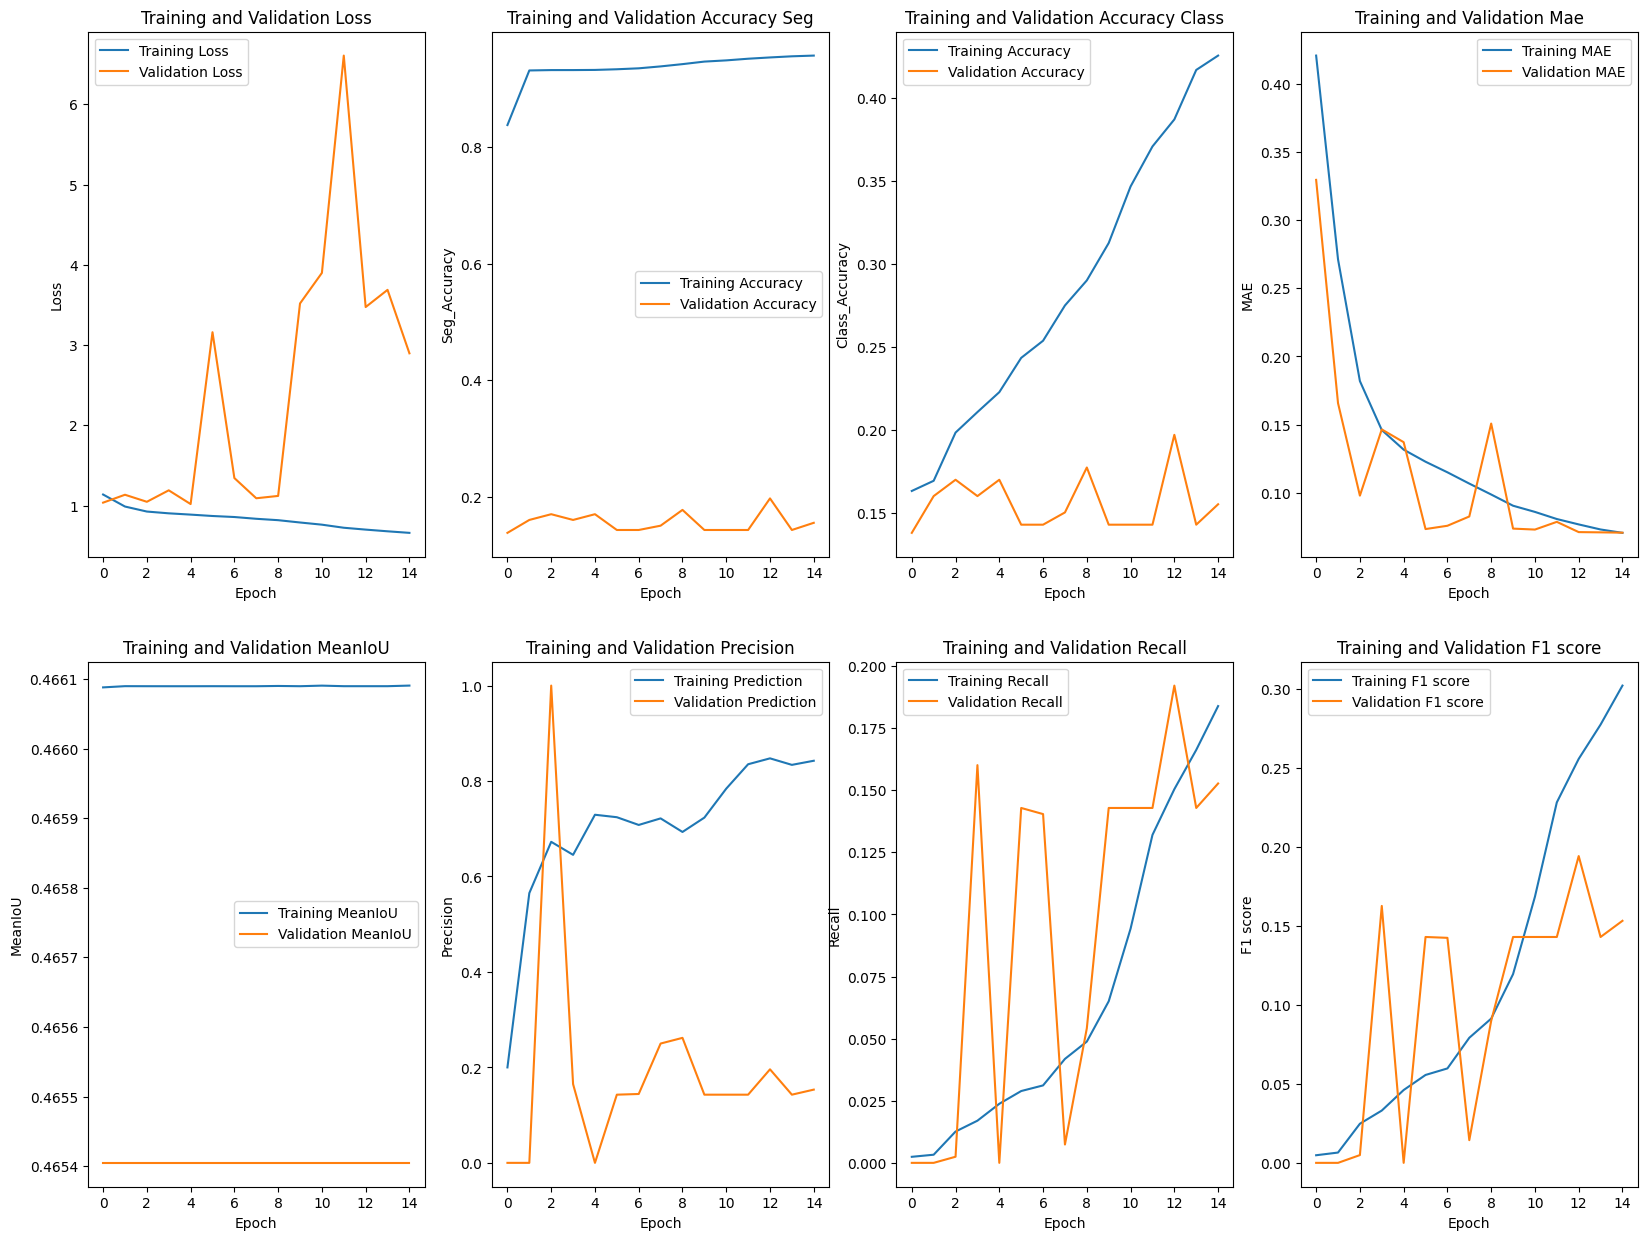

In [107]:
plt.figure(figsize = (20, 15))

plt.subplot(241)
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(242)
plt.plot(train_acc_seg, label="Training Accuracy")
plt.plot(val_acc_class, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Seg_Accuracy")
plt.title("Training and Validation Accuracy Seg")
plt.legend()

plt.subplot(243)
plt.plot(train_acc_class, label="Training Accuracy")
plt.plot(val_acc_class, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Class_Accuracy")
plt.title("Training and Validation Accuracy Class")
plt.legend()

plt.subplot(244)
plt.plot(train_mae, label="Training MAE")
plt.plot(val_mae, label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training and Validation Mae")
plt.legend()

plt.subplot(245)
plt.plot(train_mean_iou, label="Training MeanIoU")
plt.plot(val_mean_iou, label="Validation MeanIoU")
plt.xlabel("Epoch")
plt.ylabel("MeanIoU")
plt.title("Training and Validation MeanIoU")
plt.legend()

plt.subplot(246)
plt.plot(train_precision_class, label="Training Prediction")
plt.plot(val_precision_class, label="Validation Prediction")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Training and Validation Precision")
plt.legend()

plt.subplot(247)
plt.plot(train_recall_class, label="Training Recall")
plt.plot(val_recall_class, label="Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Training and Validation Recall")
plt.legend()

plt.subplot(248)
plt.plot(train_classification_f1_score, label="Training F1 score")
plt.plot(val_classification_f1_score, label="Validation F1 score")
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.title("Training and Validation F1 score")
plt.legend()

plt.show()



In [108]:
y_mask_pred, y_class_pred = model.predict(X_test)


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 519ms/step


In [109]:
predicted_labels = np.argmax(y_class_pred, axis=1)

test_labels = np.argmax(y_test_class, axis=1)


class_labels_pred = {
    0: 'missing_hole',
    1: 'mouse_bite',
    2: 'none',
    3: 'open_circuit',
    4: 'short',
    5: 'spur',
    6: 'spurious_copper'
}

remapped_labels = [class_labels_pred[label] for label in predicted_labels]

remapped_test_labels = [class_labels_pred[label] for label in test_labels]


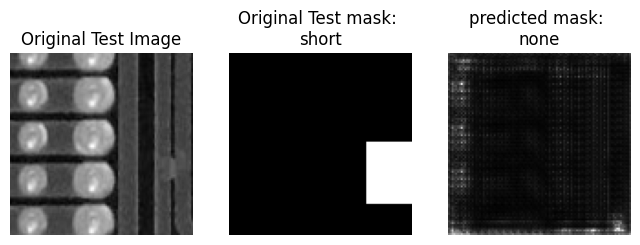

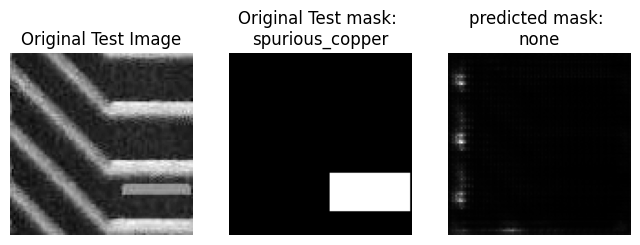

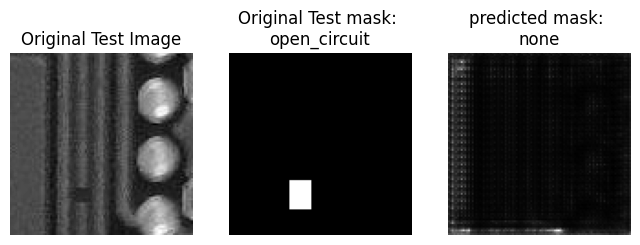

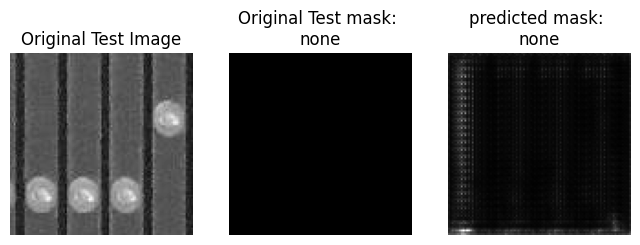

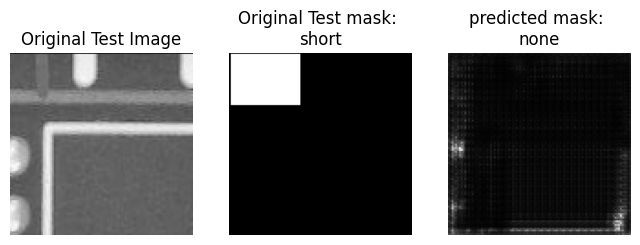

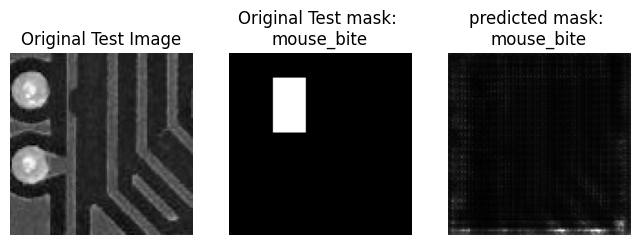

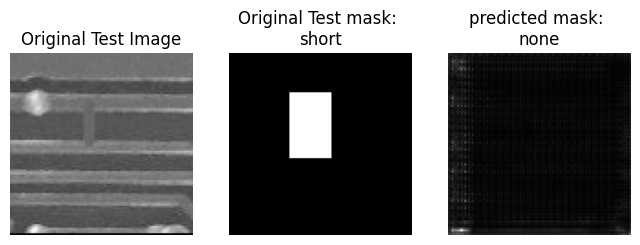

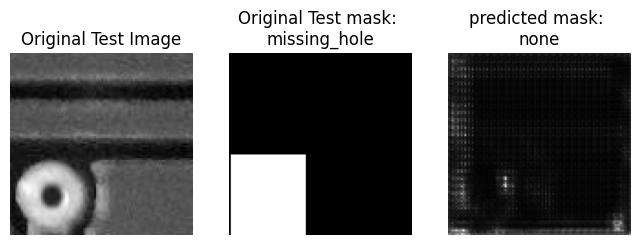

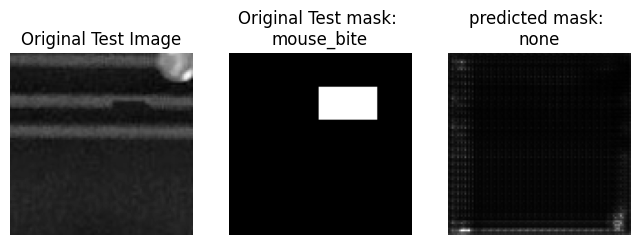

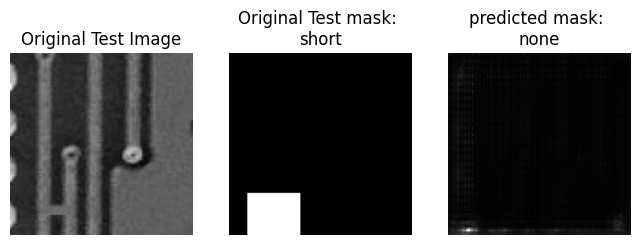

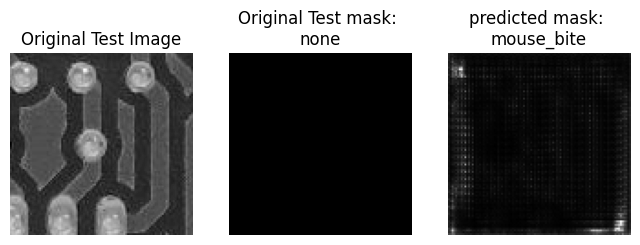

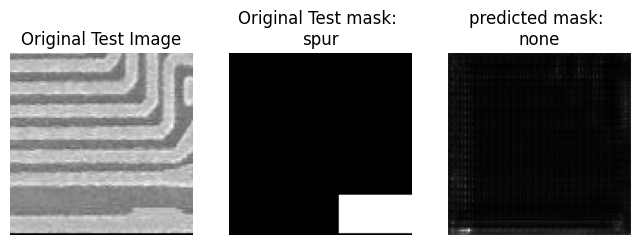

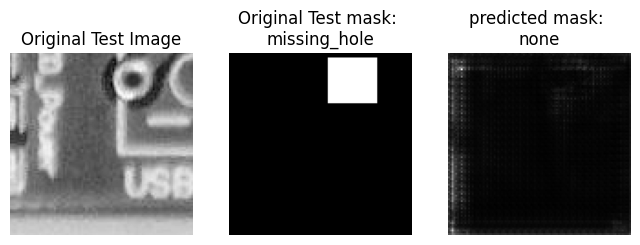

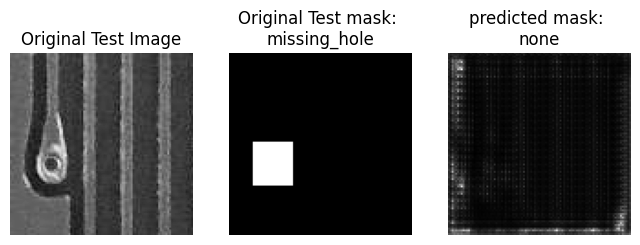

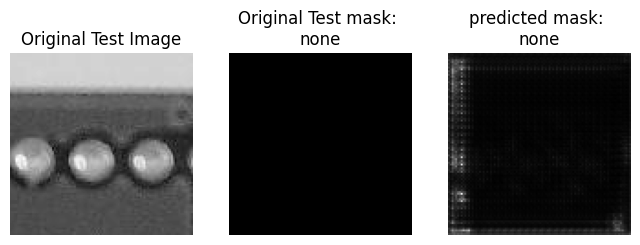

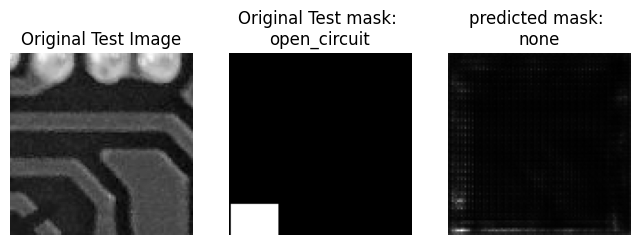

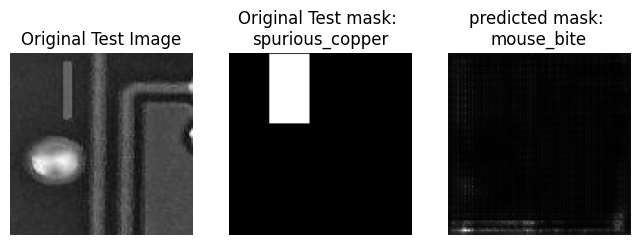

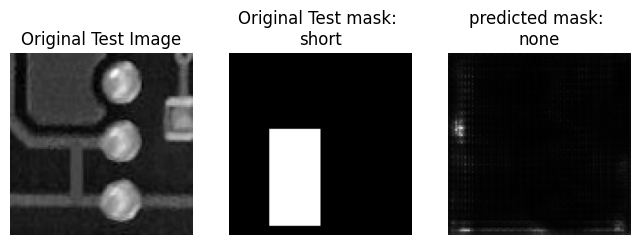

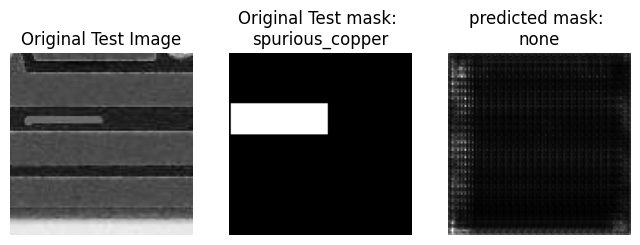

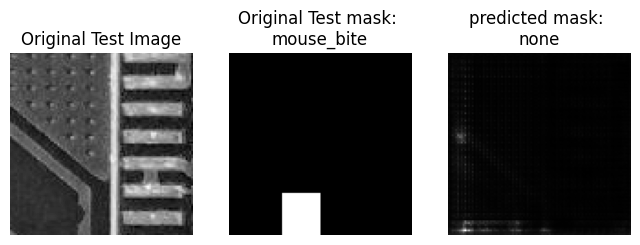

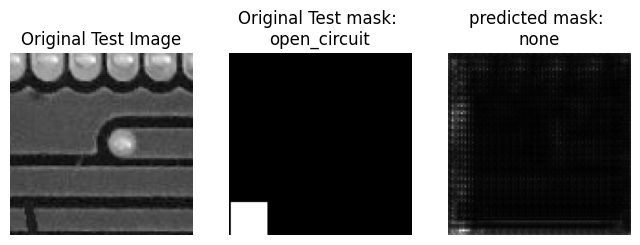

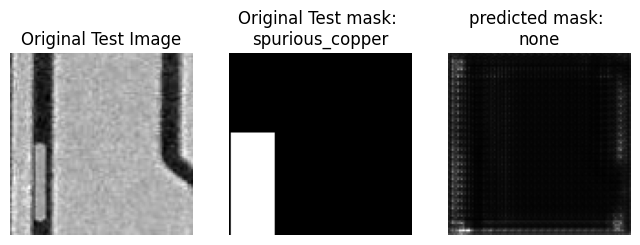

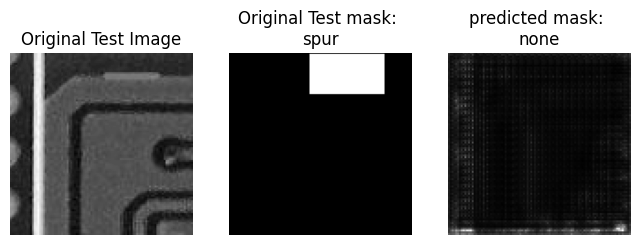

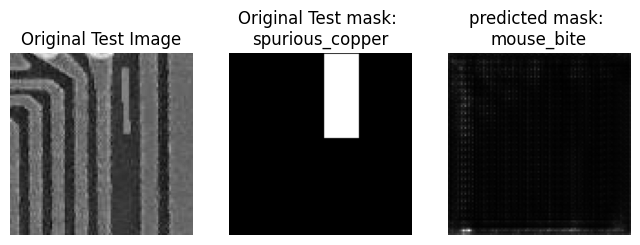

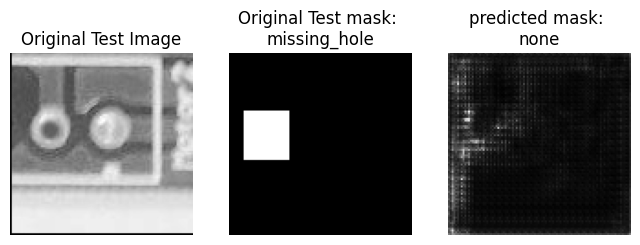

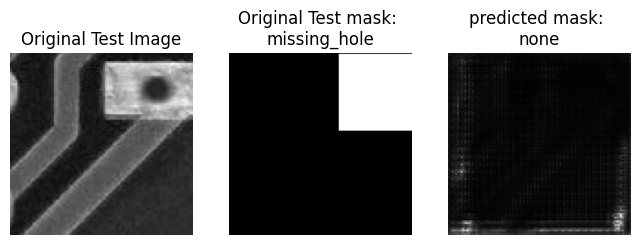

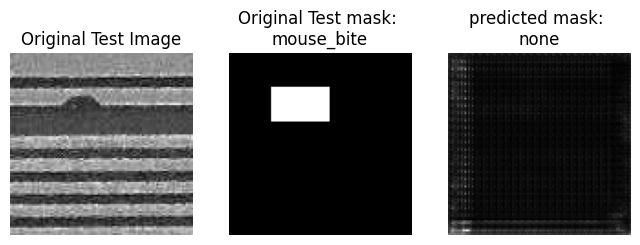

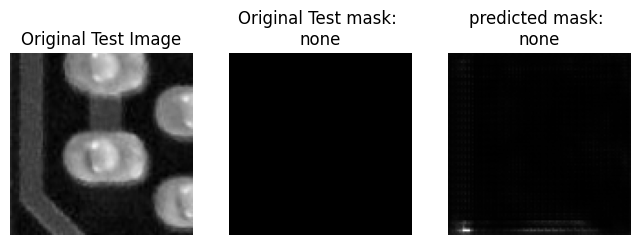

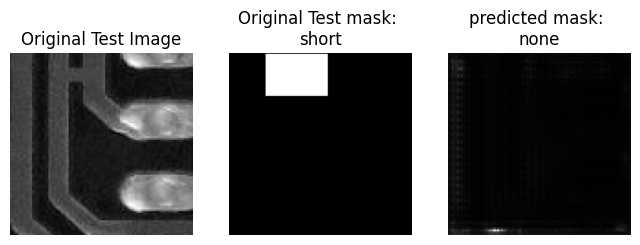

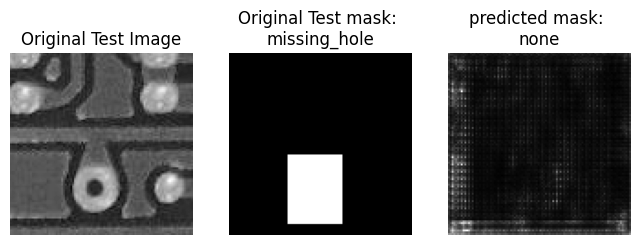

In [110]:

for i in range(0,30,1):
  
    plt.figure(figsize = (8, 5))
    plt.subplot(131) 
    plt.imshow(X_test[i].squeeze(), cmap='gray')  
    plt.title('Original Test Image')
    plt.axis('off')

    plt.subplot(132)  
    plt.imshow(y_test_mask[i].squeeze(), cmap='gray') 
    plt.title('Original Test mask: \n' + remapped_test_labels[i])
    plt.axis('off')

    plt.subplot(133)  
    plt.imshow(y_mask_pred[i].squeeze(), cmap='gray')  
    plt.title('predicted mask: \n' + remapped_labels[i])
    plt.axis('off')

    plt.show()
    



In [174]:
# Create a DataFrame for the true and predicted labels
df = pd.DataFrame({'True_Labels': remapped_test_labels, 'Predicted_Labels': remapped_labels})

# Create a crosstab
crosstab = pd.crosstab(df['True_Labels'], df['Predicted_Labels'])

print(crosstab)

Predicted_Labels  missing_hole  mouse_bite  none  open_circuit  short  spur  \
True_Labels                                                                   
missing_hole                56           0     0             0      0     0   
mouse_bite                   0          39     6             2      1     2   
none                         1           3    47             1      0     5   
open_circuit                 0           2     4            59      2     0   
short                        0           0     1             0     53     2   
spur                         0           1    15             2      0    46   
spurious_copper              0           0     1             1      0     0   

Predicted_Labels  spurious_copper  
True_Labels                        
missing_hole                    0  
mouse_bite                      0  
none                            1  
open_circuit                    2  
short                           0  
spur                            1  


In [178]:
from sklearn.metrics import classification_report
crosstab_without_none = crosstab.drop('none', axis=1).drop('none', axis=0)
report = classification_report(crosstab.index, crosstab.columns, target_names=crosstab.index)

report2 = classification_report(crosstab_without_none.index, crosstab_without_none.columns, target_names=crosstab_without_none.index)


In [179]:
print(report)

                 precision    recall  f1-score   support

   missing_hole       1.00      1.00      1.00         1
     mouse_bite       1.00      1.00      1.00         1
           none       1.00      1.00      1.00         1
   open_circuit       1.00      1.00      1.00         1
          short       1.00      1.00      1.00         1
           spur       1.00      1.00      1.00         1
spurious_copper       1.00      1.00      1.00         1

       accuracy                           1.00         7
      macro avg       1.00      1.00      1.00         7
   weighted avg       1.00      1.00      1.00         7



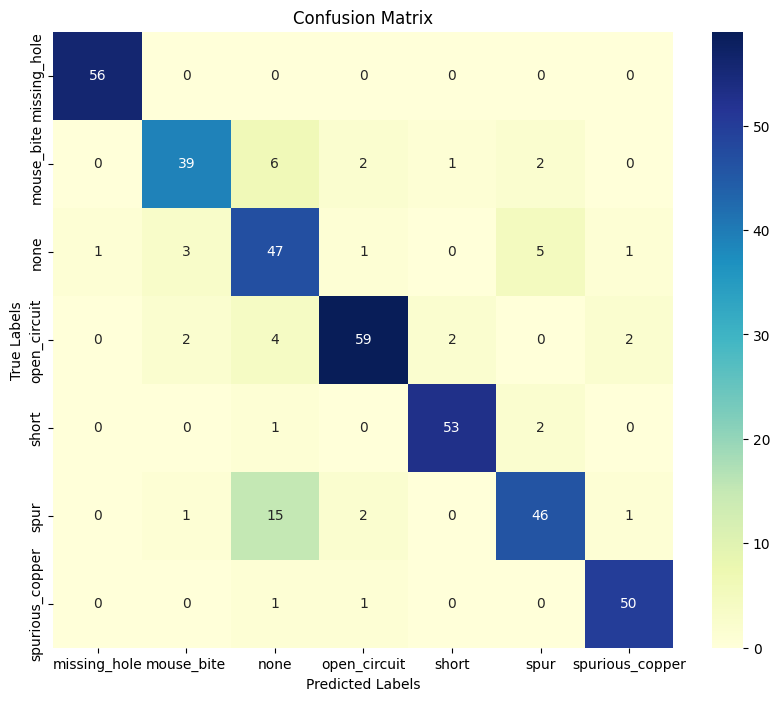

In [180]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(crosstab, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [145]:
missing_hole_indices = np.where(predicted_labels == 5)[0]  # Get the indices directly
# Get the corresponding predicted masks for missing_hole predictions
missing_hole_masks = y_mask_pred[missing_hole_indices]
missing_hole_labels = np.array(remapped_labels)[missing_hole_indices]
print(len(missing_hole_indices))
print(missing_hole_indices)

'''
# Print the predicted masks  
for i in range(len(missing_hole_indices)):
    plt.imshow(missing_hole_masks[i].squeeze(), cmap='gray') 
    plt.title('Original Test mask: \n' + missing_hole_labels[i])
    plt.axis('off')
    
    plt.show()
    '''

58
[  5   8  10  18  19  22  26  37  43  45  48  60  75  80  81  88  93  94
  97  99 112 136 143 148 151 162 171 172 179 182 186 227 231 232 238 241
 242 244 251 267 288 292 297 325 331 337 359 360 366 367 376 379 386 394
 398 400 404 405]


"\n# Print the predicted masks  \nfor i in range(len(missing_hole_indices)):\n    plt.imshow(missing_hole_masks[i].squeeze(), cmap='gray') \n    plt.title('Original Test mask: \n' + missing_hole_labels[i])\n    plt.axis('off')\n    \n    plt.show()\n    "

In [181]:
image_test2 = []
gray_image2 = []
image_test2 = cv2.imread('C:/users/wfaiz/Data_Science/PCB_Defect/data_full/Images/l_light_11_spur_02_5_600.jpg')

image_test2 = cv2.resize(image_test2, (600, 600))  # Resize
gray_image2 = cv2.cvtColor(image_test2, cv2.COLOR_BGR2GRAY)
image_array_test2 = np.asarray(gray_image2) / 255.0 #normalize

In [182]:
image_array_test2 = np.expand_dims(image_array_test2, axis=0)  # Add batch dimension
y_pred2, y_class2 = model.predict(image_array_test2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step


In [183]:
print(y_class2)
predicted_label2 = np.argmax(y_class2, axis=1)
remapped_label2 = [class_labels_pred[label] for label in predicted_label2]

# Print the remapped labels
print("Remapped Labels:", remapped_label2)

[[2.2795002e-04 7.4108643e-03 9.8855305e-01 1.2017760e-03 3.2597804e-05
  2.5024815e-03 7.1320770e-05]]
Remapped Labels: ['none']


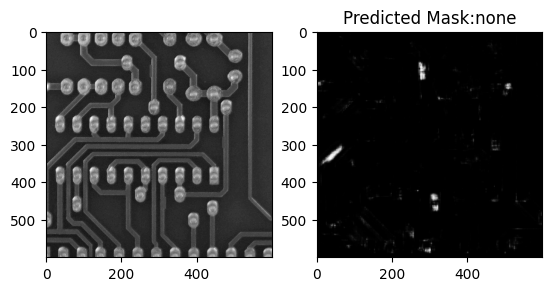

In [184]:

plt.subplot(121) 
plt.imshow(gray_image2.squeeze(), cmap='gray')

plt.subplot(122) 
plt.imshow(y_pred2.squeeze(), cmap='gray')
plt.title('Predicted Mask:' +remapped_label2[0])
plt.show()

In [191]:
image_test3 = []
gray_image3 = []
image_test3 = cv2.imread('C:/users/wfaiz/Data_Science/PCB_Defect/data_full/Images/l_light_01_missing_hole_17_3_600.jpg')

image_test3 = cv2.resize(image_test3, (600, 600))  # Resize
gray_image3 = cv2.cvtColor(image_test3, cv2.COLOR_BGR2GRAY)
image_array_test3 = np.asarray(gray_image3) / 255.0 #normalize


In [198]:
def crop_image(image, crop_size=(100, 100)):
    crops = []
    height, width = image.shape
    crop_height, crop_width = crop_size

    for i in range(0, height, crop_height):
        for j in range(0, width, crop_width):
            crop = image[i:i + crop_height, j:j + crop_width]
            if crop.shape[0] == crop_height and crop.shape[1] == crop_width:
                crops.append(crop)
    return crops

# Crop the normalized grayscale image into 100x100 sections
crops = np.asarray(crop_image(image_array_test3, crop_size=(100, 100)))


In [199]:
print(X_test.shape)
print(crops.shape)

(406, 100, 100)
(36, 100, 100)


In [200]:
y_pred3, y_class3 = model.predict(crops)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


In [ ]:
print(y_class3)
predicted_label3 = np.argmax(y_class3, axis=1)
remapped_label3 = [class_labels_pred[label] for label in predicted_label3]

# Print the remapped labels
print("Remapped Labels:", remapped_label3)

In [202]:
def combine_crops(crops, crop_size=(100, 100), full_size=(600, 600)):
    rows = full_size[0] // crop_size[0]
    cols = full_size[1] // crop_size[1]
    combined_image = np.zeros(full_size)

    crop_idx = 0
    for i in range(rows):
        for j in range(cols):
            combined_image[i*crop_size[0]:(i+1)*crop_size[0], j*crop_size[1]:(j+1)*crop_size[1]] = crops[crop_idx]
            crop_idx += 1
    return combined_image

In [207]:
X_test_combined = combine_crops(crops)
#y_test_mask_combined = combine_crops(y_pred3.squeeze())
y_mask_pred_combined = combine_crops(y_pred3.squeeze())

In [213]:
crop_idx = 0
class_test = []
for i in range(0, 600, 100):
    for j in range(0, 600, 100):
        if y_class3.squeeze()[crop_idx] != 'none':
            class_test.append(y_class3)
        crop_idx += 1

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

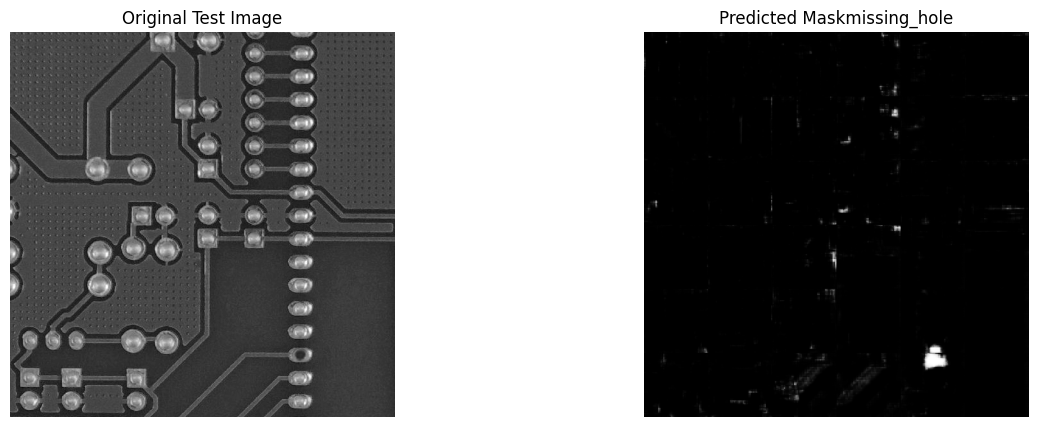

In [215]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.imshow(X_test_combined, cmap='gray')
plt.title('Original Test Image')
plt.axis('off')


plt.subplot(122)
plt.imshow(y_mask_pred_combined, cmap='gray')
plt.title('Predicted Mask' +remapped_label3[34])
plt.axis('off')

plt.show()

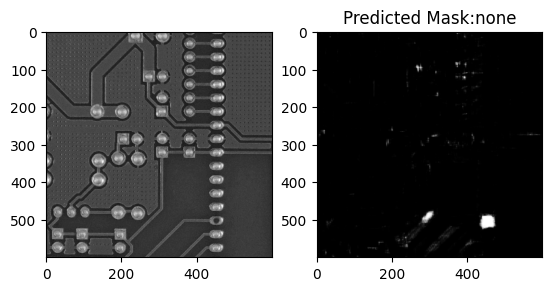

In [188]:

plt.subplot(121) 
plt.imshow(gray_image3.squeeze(), cmap='gray')

plt.subplot(122) 
plt.imshow(y_pred3.squeeze(), cmap='gray')
plt.title('Predicted Mask:' +remapped_label3[0])
plt.show()

In [237]:
# Load the model from a file
from tensorflow.keras.models import load_model
model_path = 'model_enhanced_res_unet_2.keras'
model = load_model(model_path)

TypeError: Could not locate function 'iou'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'iou', 'registered_name': 'function'}